In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

plt.style.use('seaborn-v0_8')

In [ ]:

# Load datasets

listings = pd.read_csv("/content/listings.csv")
calendar = pd.read_csv("/content/calendar.csv")
reviews = pd.read_csv("/content/reviews.csv")

print(calendar.info())
print(listings.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                    

In [ ]:
#Calendar
calendar_c = calendar.dropna(subset=['price']).copy()

calendar_c['price'] = (
    calendar_c['price']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

calendar_c['date'] = pd.to_datetime(calendar_c['date'])
calendar_c['month'] = calendar_c['date'].dt.month
calendar_c['day_of_week'] = calendar_c['date'].dt.day_name()


<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3588684312.py:5: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


In [ ]:

# Listings Data Cleaning

listings['price'] = (
    listings['price']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

best = listings[listings['review_scores_rating'] >= 90]
print("Total listings:", listings.shape[0])
print("High-rated listings:", best.shape[0])


Total listings: 3585
High-rated listings: 2052


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2949782733.py:6: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


In [ ]:

#Listings Data Cleaning
listings['price'] = (
    listings['price']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

best = listings[listings['review_scores_rating'] >= 90]
print("Total listings:", listings.shape[0])
print("High-rated listings:", best.shape[0])


Total listings: 3585
High-rated listings: 2052


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2949782733.py:6: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


In [ ]:

#  Feature Selection
features = ['bedrooms', 'bathrooms', 'property_type', 'room_type']
model_data = listings.dropna(subset=features + ['price'])

X = model_data[features]
y = model_data['price']


In [ ]:

# Preprocessing

categorical_features = ['property_type', 'room_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'),
         categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)


In [ ]:

# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Train Model

lr = LinearRegression()
lr.fit(X_train, y_train)


# Predictions

y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.2f}")


R-squared score: 0.42


In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

calendar_c['season'] = calendar_c['month'].apply(get_season)


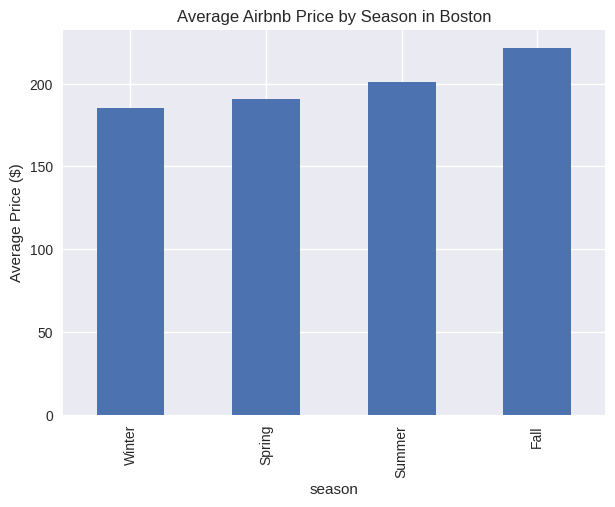

In [ ]:
# Average Airbnb Price by Season in Boston
season_price = calendar_c.groupby('season')['price'].mean().reindex(
    ['Winter', 'Spring', 'Summer', 'Fall']
)

plt.figure(figsize=(7,5))
season_price.plot(kind='bar')
plt.ylabel('Average Price ($)')
plt.title('Average Airbnb Price by Season in Boston')
plt.show()


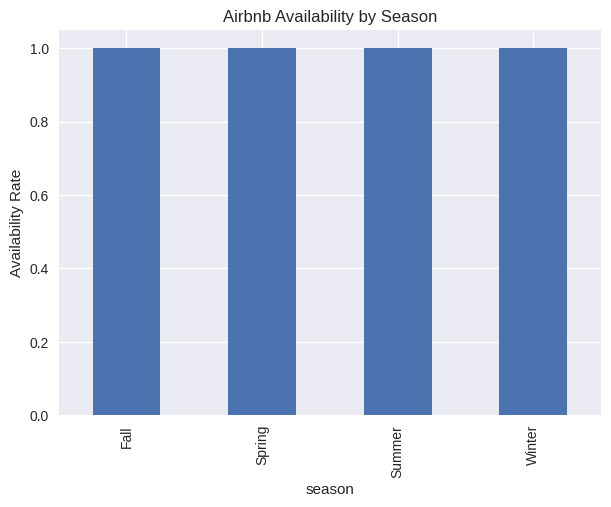

In [ ]:
#Airbnb availability by season
calendar_c['available_flag'] = calendar_c['available'].map({'t': 1, 'f': 0})

season_availability = calendar_c.groupby('season')['available_flag'].mean()

plt.figure(figsize=(7,5))
season_availability.plot(kind='bar')
plt.ylabel('Availability Rate')
plt.title('Airbnb Availability by Season')
plt.show()


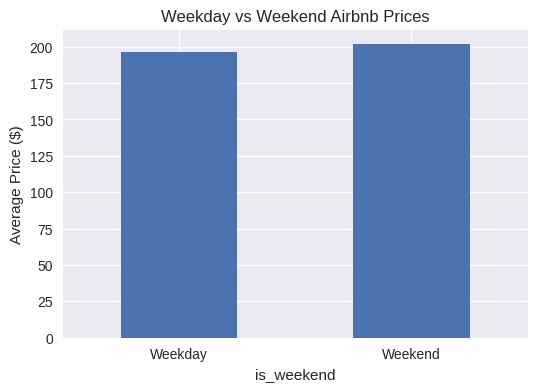

In [ ]:
#weekday and Weekend price
calendar_c['is_weekend'] = calendar_c['day_of_week'].isin(
    ['Friday', 'Saturday', 'Sunday']
)

weekend_price = calendar_c.groupby('is_weekend')['price'].mean()

plt.figure(figsize=(6,4))
weekend_price.plot(kind='bar')
plt.xticks([0,1], ['Weekday', 'Weekend'], rotation=0)
plt.ylabel('Average Price ($)')
plt.title('Weekday vs Weekend Airbnb Prices')
plt.show()


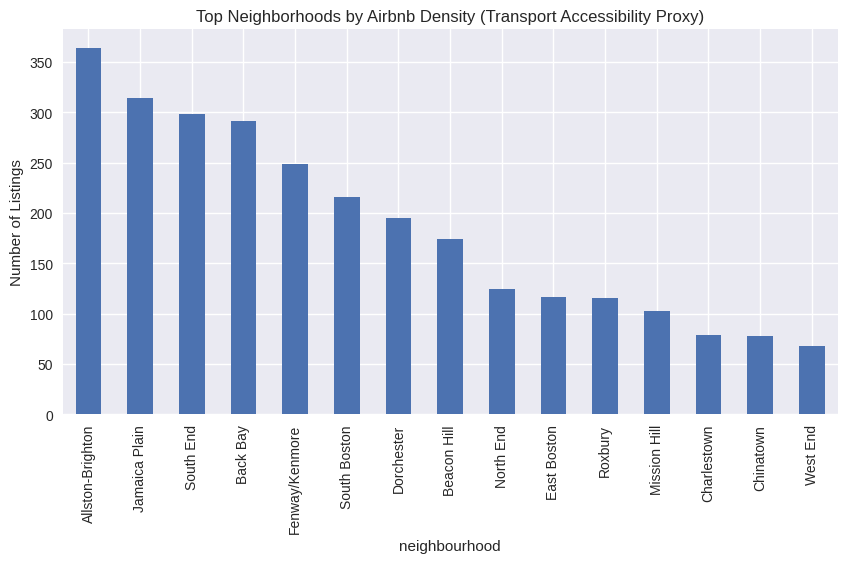

In [ ]:
#Neighbourhood density
neighborhood_density = listings.groupby('neighbourhood')['id'].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
neighborhood_density.head(15).plot(kind='bar')
plt.ylabel('Number of Listings')
plt.title('Top Neighborhoods by Airbnb Density (Transport Accessibility Proxy)')
plt.show()


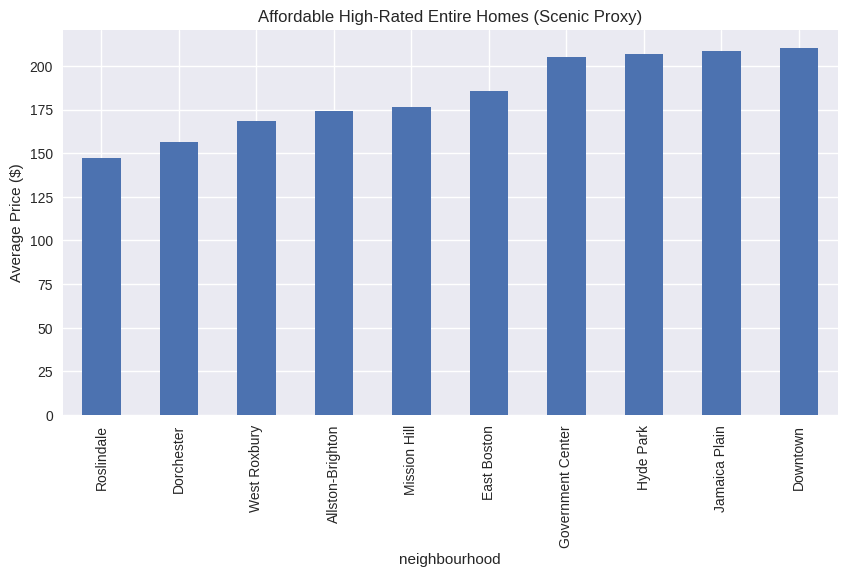

In [ ]:
scenic_proxy = listings[
    (listings['review_scores_rating'] >= 90) &
    (listings['room_type'] == 'Entire home/apt')
].copy()

# Explicitly ensure the 'price' column in scenic_proxy is numeric
# This is a safeguard in case the dtype was not correctly carried over or reverted.
if scenic_proxy['price'].dtype == 'object':
    scenic_proxy['price'] = (
        scenic_proxy['price']
        .replace('[$,]', '', regex=True)
        .astype(float)
    )

scenic_price_by_neighborhood = (
    scenic_proxy.groupby('neighbourhood')['price']
    .mean()
    .sort_values()
    .head(10)
)

plt.figure(figsize=(10,5))
scenic_price_by_neighborhood.plot(kind='bar')
plt.ylabel('Average Price ($)')
plt.title('Affordable High-Rated Entire Homes (Scenic Proxy)')
plt.show()

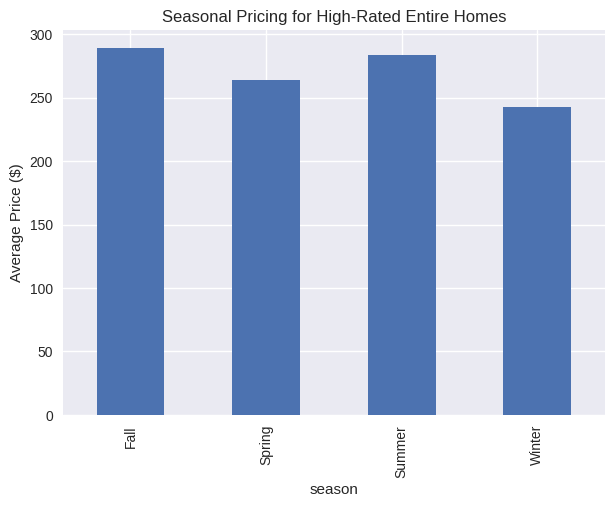

In [ ]:
#Season Scenic
season_scenic = calendar_c.merge(
    listings[['id', 'neighbourhood', 'room_type', 'review_scores_rating']],
    left_on='listing_id',
    right_on='id',
    how='inner'
)

season_scenic_filtered = season_scenic[
    (season_scenic['review_scores_rating'] >= 90) &
    (season_scenic['room_type'] == 'Entire home/apt')
]

seasonal_scenic_price = season_scenic_filtered.groupby('season')['price'].mean()

plt.figure(figsize=(7,5))
seasonal_scenic_price.plot(kind='bar')
plt.ylabel('Average Price ($)')
plt.title('Seasonal Pricing for High-Rated Entire Homes')
plt.show()


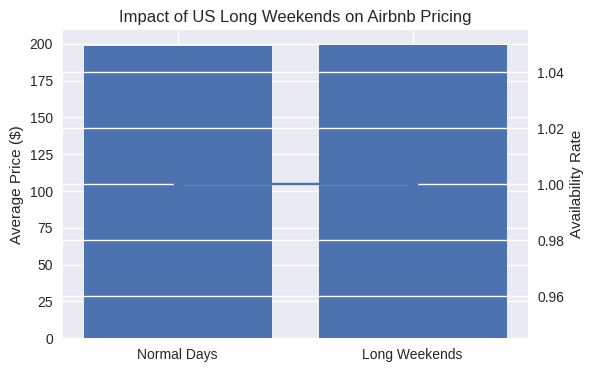

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create holiday calendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(
    start=calendar_c['date'].min(), # Use calendar_c
    end=calendar_c['date'].max()
)

calendar_c['is_holiday'] = calendar_c['date'].isin(holidays) # Add is_holiday to calendar_c

# Long weekend proxy:
# weekend + adjacent holiday
calendar_c['is_long_weekend'] = (
    (calendar_c['is_weekend']) & # Use calendar_c
    (calendar_c['is_holiday'].shift(1, fill_value=False) |
     calendar_c['is_holiday'] |
     calendar_c['is_holiday'].shift(-1, fill_value=False))
)

holiday_summary = calendar_c.groupby( # Use calendar_c
    ['is_long_weekend']
).agg(
    avg_price=('price', 'mean'),
    availability=('available_flag', 'mean')
)

holiday_summary.index = ['Normal Days', 'Long Weekends']

# Plot
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(holiday_summary.index, holiday_summary['avg_price'])
ax1.set_ylabel("Average Price ($)")
ax1.set_title("Impact of US Long Weekends on Airbnb Pricing")

ax2 = ax1.twinx()
ax2.plot(holiday_summary.index, holiday_summary['availability'], marker='o')
ax2.set_ylabel("Availability Rate")

plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3383493967.py:6: SyntaxWarning: invalid escape sequence '\$'
  geo['price'] = geo['price'].replace('[\$,]', '', regex=True).astype(float)


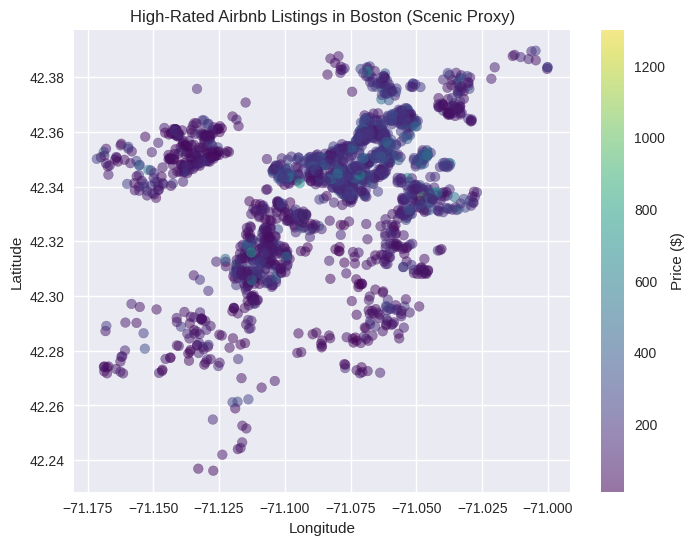

In [ ]:
# Clean geo data
geo = listings.dropna(subset=[
    'latitude', 'longitude', 'review_scores_rating', 'price'
]).copy()

geo['price'] = geo['price'].replace('[\$,]', '', regex=True).astype(float)

# Scenic proxy
geo = geo[geo['review_scores_rating'] >= 90]

plt.figure(figsize=(8,6))
plt.scatter(
    geo['longitude'],
    geo['latitude'],
    c=geo['price'],
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(label='Price ($)')
plt.title("High-Rated Airbnb Listings in Boston (Scenic Proxy)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


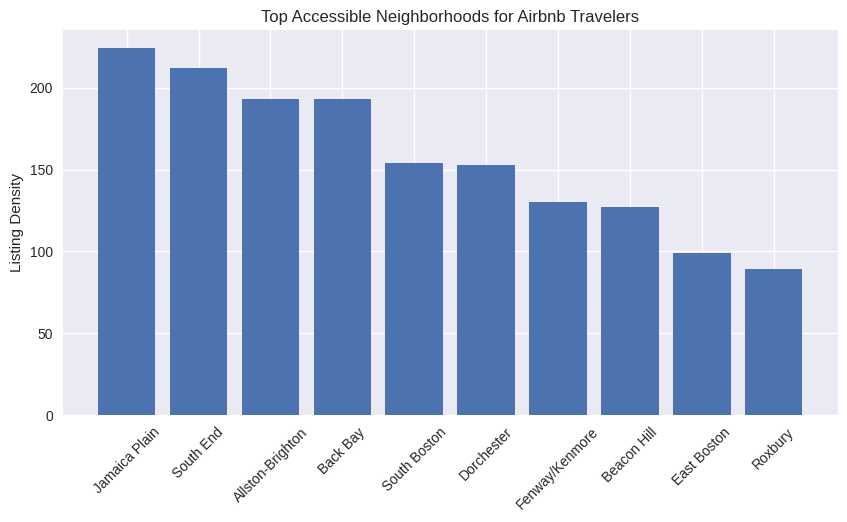

In [ ]:
# Merge calendar availability with listings
availability_by_listing = calendar_c.groupby('listing_id').agg(
    availability_rate=('available_flag', 'mean')
).reset_index()

access = listings.merge(
    availability_by_listing,
    left_on='id',
    right_on='listing_id',
    how='inner'
)

access = access.dropna(subset=[
    'neighbourhood', 'availability_rate', 'review_scores_rating'
])

access_summary = access.groupby('neighbourhood').agg(
    listing_density=('id', 'count'),
    avg_availability=('availability_rate', 'mean'),
    avg_rating=('review_scores_rating', 'mean')
).sort_values('listing_density', ascending=False).head(10)

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(access_summary.index, access_summary['listing_density'])
ax.set_ylabel("Listing Density")
ax.set_title("Top Accessible Neighborhoods for Airbnb Travelers")
plt.xticks(rotation=45)
plt.show()